In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge/jupyter notebooks
Current path:/Users/gregory/PROJECT_ML/VESUVIUS_Challenge


In [2]:
import torch
import monai
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.Vesuvius_Tile_Dataset import Vesuvius_Tile_Datamodule
import matplotlib.patches as patches
from lit_models.UNET_TILE import UNET_TILE_lit
from monai.visualize import matshow3d
import einops
from pytorch_lightning.callbacks import ModelCheckpoint
from pathlib import Path
from typing import Tuple
import monai
import numpy as np
import pandas as pd
import PIL.Image as Image
import pytorch_lightning as pl
import seaborn as sns
import torch
from torchmetrics import Dice,  FBetaScore
from torchmetrics import MetricCollection
from tqdm.auto import tqdm
from typing import Tuple, List
import os
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import cv2
import numpy as np
import gc
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

2023-05-04 15:18:20,283 - Created a temporary directory at /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmphlykkqc3
2023-05-04 15:18:20,284 - Writing /var/folders/wc/60y8v25x3ns_jgsx6clbdb180000gn/T/tmphlykkqc3/_remote_module_non_scriptable.py


In [3]:
KAGGLE_DIR = PATH / "kaggle"

INPUT_DIR = KAGGLE_DIR / "input"

COMPETITION_DATA_DIR = INPUT_DIR / "vesuvius-challenge-ink-detection"

TRAIN_DATA_CSV_PATH = COMPETITION_DATA_DIR / "data_train_0.5.csv"
TEST_DATA_CSV_PATH = COMPETITION_DATA_DIR / "data_test_1.csv"
TEST_DOWNSAMPLED_DATA_CSV_PATH = COMPETITION_DATA_DIR /"data_test_0.5.csv"
TEST_DOWNSAMPLED_HALf_DATA_CSV_PATH = COMPETITION_DATA_DIR /"data_test_0.75.csv"

In [12]:
CHECKPOINT = 'logs/BCE1_SMPEffB2_Tile_12_224patch/BCE1_SMPEffB2_Tile_12_224patchepoch=09val_loss=0.26fbeta_4=0.28recall=nanprecision=nan.ckpt'
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"


In [5]:
PATCH_SIZE = 224
Z_DIM = 10

class CFG:
    
    train_fragment_id=[2,3]
    val_fragment_id=[1]
    batch_size = 32
    patch_size = PATCH_SIZE
    z_dim = Z_DIM
    stride = patch_size // 2
    #comp_dataset_path = COMPETITION_DATA_DIR
    num_workers = 0
    on_gpu = True
    test_fragment_ids = ['a','b']

In [6]:
dataset = Vesuvius_Tile_Datamodule(cfg=CFG)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
lit_model = UNET_TILE_lit(
        use_wandb = False,
        z_dim = Z_DIM,
        patch_size = (PATCH_SIZE,PATCH_SIZE),
        sw_batch_size=8 ,
        eta_min = 1e-7,
        t_max = 120,
        max_epochs = 1000,
        weight_decay =  1e-6,
        learning_rate = 0.0001,
        gamma = 0.85,)


lit_model = lit_model.load_from_checkpoint(CHECKPOINT, 
                                           patch_size = (PATCH_SIZE,PATCH_SIZE),
                                           use_wandb=False,
                                          sw_batch_size = 4,
                                          ).to(DEVICE)

lit_model.eval()

UNET_TILE_lit(
  (metrics): ModuleDict(
    (train_metrics): MetricCollection(
      (dice): Dice(),
      prefix=train_
    )
    (val_metrics): MetricCollection(
      (dice): Dice(),
      prefix=val_
    )
  )
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        10, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), st

In [8]:
def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    
    x1_list = list(range(0, test_images.shape[1]-CFG.patch_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.patch_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.patch_size
            x2 = x1 + CFG.patch_size
            
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))
    
    test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=False, drop_last=False)
    
    return test_loader, xyxys


def get_transforms(data, cfg):
    return A.Compose(
        [
        A.Resize(PATCH_SIZE, PATCH_SIZE),
        A.Normalize(
            mean=[0] * Z_DIM,
            std=[1] * Z_DIM
        ),

        ToTensorV2(transpose_mask=True),
    ]
    )

def read_image(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.z_dim // 2
    end = mid + CFG.z_dim // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.patch_size - image.shape[0] % CFG.patch_size)
        pad1 = (CFG.patch_size - image.shape[1] % CFG.patch_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image
    
    
    
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

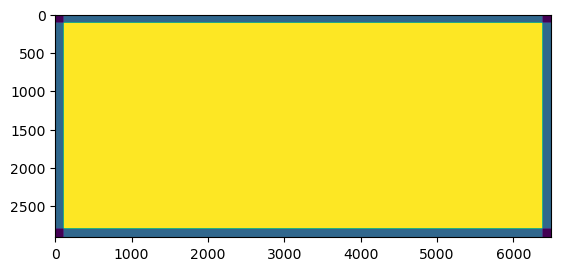

mask_count_min: 1.0


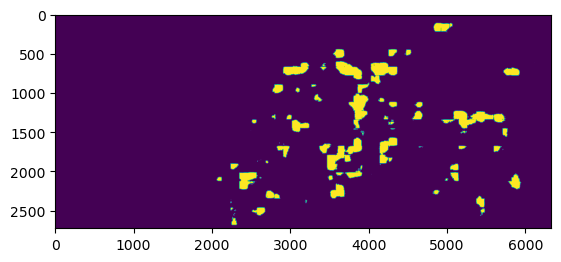

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

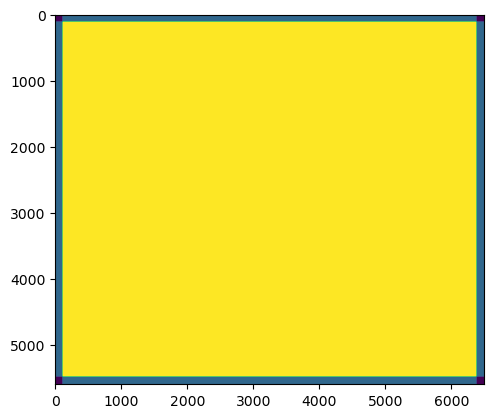

mask_count_min: 1.0


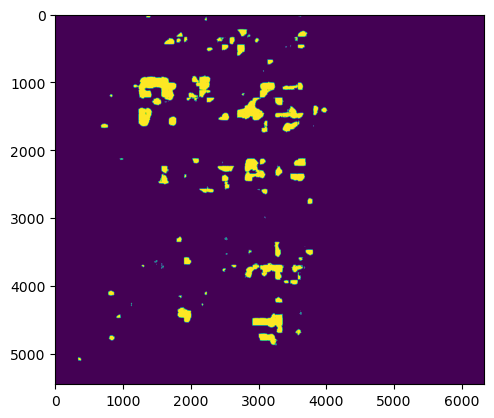

In [9]:
THRESHOLD =0.4
results = []
for fragment_id in CFG.test_fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    binary_mask = torch.tensor(binary_mask)#.to(DEVICE)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.patch_size - binary_mask.shape[0] % CFG.patch_size)
    pad1 = (CFG.patch_size - binary_mask.shape[1] % CFG.patch_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = torch.zeros(binary_mask.shape).to(DEVICE)
    mask_count = torch.zeros(binary_mask.shape).to(DEVICE)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(DEVICE)
        batch_size = images.size(0)
        
        with torch.no_grad():
            y_preds = lit_model(images)
            #y_preds = y_preds.numpy()
            #print(type(y_preds))

        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        #xyxys = torch.from_numpy(xyxys)
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += torch.ones((CFG.patch_size, CFG.patch_size)).to(DEVICE)
    
    plt.imshow(mask_count.to('cpu'))
    plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = mask_pred.to('cpu').numpy()
    mask_pred = (mask_pred >= THRESHOLD).astype(int)
    mask_pred *= binary_mask
    
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append( inklabels_rle)
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    
    


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

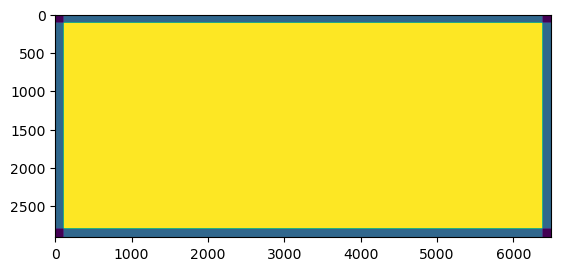

mask_count_min: 1.0


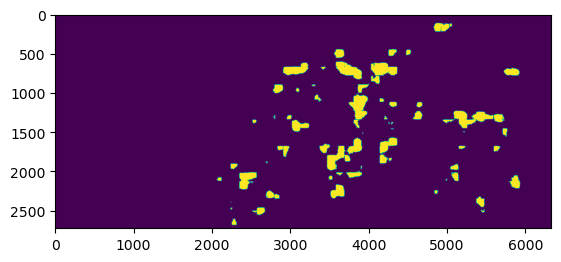

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

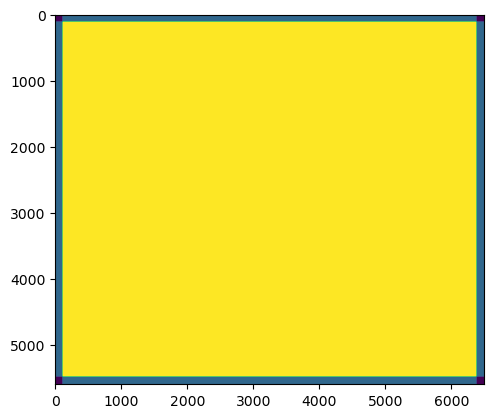

mask_count_min: 1.0


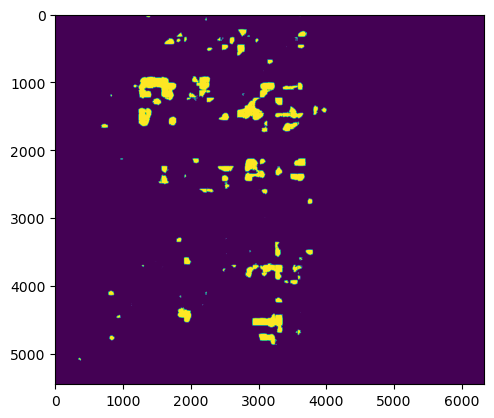

In [13]:
THRESHOLD =0.5
results = []
preds = []
for fragment_id in CFG.test_fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    binary_mask = torch.tensor(binary_mask)#.to(DEVICE)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.patch_size - binary_mask.shape[0] % CFG.patch_size)
    pad1 = (CFG.patch_size - binary_mask.shape[1] % CFG.patch_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = torch.zeros(binary_mask.shape).to(DEVICE)
    mask_count = torch.zeros(binary_mask.shape).to(DEVICE)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(DEVICE)
        batch_size = images.size(0)
        
        with torch.no_grad():
            y_preds = lit_model(images)
            #y_preds = y_preds.numpy()
            #print(type(y_preds))

        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        #xyxys = torch.from_numpy(xyxys)
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += torch.ones((CFG.patch_size, CFG.patch_size)).to(DEVICE)
    
    plt.imshow(mask_count.to('cpu'))
    plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = mask_pred.to('cpu').numpy()
    mask_pred = (mask_pred >= THRESHOLD).astype(int)
    mask_pred *= binary_mask
    
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append( inklabels_rle)
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    
    


In [11]:
mask_preds

NameError: name 'mask_preds' is not defined